# Valuation of a Company

If you have watched Shark Tank, the judges try to offer deals on a certain valuation based on different parameters. Revenue, Gross Profit, Net Profit, Quarter on Quarter are some of these parameters. This got me wondering how do these judges calculate what valuation should be given using these parameters. Which parameter mattered the most? Which parameter would hold more weightage in a particular sector? How do you know that a certain valuation was a fair valuation?

So I decided a to build a Multiple Linear Regression Model to predict the valuation of companies belonging to a particular sector (to be precise of Sugar Sector). Then this Linear Regression Model can help me tell which companies are overbought and which companies are underbought.

Because I have good knowledge of the Stock Market, I compiled all the data in an excel sheet first, used the required formulas to get the necessary ratios and then converted it into a .csv file so that I can do the necessary analysis, pre-processing and build my Linear Regression Model.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import piplite
await piplite.install('seaborn')
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sugar = pd.read_csv('Sugar_Stocks.csv')
sugar.head()

,BSE Code,Stock,Current Ratio,R&S to SEC,Debt to Equity Ratio,ROCE,ROA,EBIT CAGR 5 yrs,EBIT CAGR 4 yrs,EBIT CAGR 3 yrs,...,Revenue CQGR 3 yrs,Revenue CQGR 2 yrs,Profit CQGR 5 yrs,Profit CQGR 4 yrs,Profit CQGR 3 yrs,Profit CQGR 2 yrs,Revenue CAGR 5 yrs,Revenue CAGR 4 yrs,Revenue CAGR 3 yrs,Revenue CAGR 2 yrs
0,540649.0,AVADHSUGAR,0.999737,43.513487,0.392556,18.801624,12.368244,6.124210,8.302683677,5.378462,...,-2.707555,-5.724802,3.166085,-15.863629,-4.148970,-5.242808,2.65,1.48,1.25,0.82
1,500032.0,BAJAJHIND,0.558991,33.820249,1.217212,0.836888,0.786733,-12.784389,#NUM!,292.790885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500038.0,BALRAMCHIN,1.312208,142.558255,0.196338,21.656004,16.087258,6.936559,8.553908862,12.235080,...,-1.740000,-5.000000,7.307715,-22.434635,-7.022347,-7.214849,4.07,3.84,4.00,4.32
3,500041.0,BANARISUG,2.035795,122.755183,0.150475,15.037668,12.871606,12.258032,18.53220349,25.634484,...,12.239945,5.048123,4.089233,3.016345,22.398397,5.278378,8.82,9.41,4.21,-0.81
4,500097.0,DALMIASUG,2.727220,166.075355,0.216115,12.255718,12.485176,6.888197,2.484836337,4.597770,...,-6.348413,-5.060000,-0.575474,-12.049820,-1.603339,10.783676,9.38,4.42,1.99,0.43


### Cleaning

I can see that there are some missing values in this Dataset. Let us clean them first.
Then I can see that there are some columns that do not have the appropriate data type due to formatting. So I will format them and assign them the appropriate data types.

In [4]:
sugar = sugar.dropna()

In [5]:
sugar['NoS'] = sugar['NoS'].str.replace(',', '').astype(int)

In [6]:
sugar['Revenue'] = sugar['Revenue'].str.replace(',', '').astype(float)

In [7]:
sugar['BV'] = sugar['BV'].str.replace(',', '').astype(float)

In [8]:
sugar['EBIT CAGR 4 yrs'] = sugar['EBIT CAGR 4 yrs'].str.replace(',', '').astype(float)

In [9]:
sugar['EBIT CAGR 2 yrs'] = sugar['EBIT CAGR 2 yrs'].str.replace(',', '').astype(float)

Let's check the data types before moving forward.

In [10]:
sugar.dtypes

BSE Code                     float64
Stock                         object
Current Ratio                float64
R&S to SEC                   float64
Debt to Equity Ratio         float64
ROCE                         float64
ROA                          float64
EBIT CAGR 5 yrs              float64
EBIT CAGR 4 yrs              float64
EBIT CAGR 3 yrs              float64
EBIT CAGR 2 yrs              float64
P/E                          float64
Revenue                      float64
Public Shareholding          float64
LTP                          float64
BV                           float64
NoS                            int32
P/BV                         float64
Correction from 52wk high    float64
Revenue CQGR 5 yrs           float64
Revenue CQGR 4 yrs           float64
Revenue CQGR 3 yrs           float64
Revenue CQGR 2 yrs           float64
Profit CQGR 5 yrs            float64
Profit CQGR 4 yrs            float64
Profit CQGR 3 yrs            float64
Profit CQGR 2 yrs            float64
R

Because we want to make a valuation model, it would be fair to introduce a new column called for Market Capital. For those of you who don't know, Market Capital is just another name for valuation. The formula for Market Cap is Number of Shares of a company multiplied by its Last Trading Price.

In [11]:
sugar['mcap'] = sugar['NoS'] * sugar['LTP']

In [12]:
sugar.head()

,BSE Code,Stock,Current Ratio,R&S to SEC,Debt to Equity Ratio,ROCE,ROA,EBIT CAGR 5 yrs,EBIT CAGR 4 yrs,EBIT CAGR 3 yrs,...,Revenue CQGR 2 yrs,Profit CQGR 5 yrs,Profit CQGR 4 yrs,Profit CQGR 3 yrs,Profit CQGR 2 yrs,Revenue CAGR 5 yrs,Revenue CAGR 4 yrs,Revenue CAGR 3 yrs,Revenue CAGR 2 yrs,mcap
0,540649.0,AVADHSUGAR,0.999737,43.513487,0.392556,18.801624,12.368244,6.124210,8.302684,5.378462,...,-5.724802,3.166085,-15.863629,-4.148970,-5.242808,2.650000,1.480000,1.250000,0.820000,1.164158e+10
2,500038.0,BALRAMCHIN,1.312208,142.558255,0.196338,21.656004,16.087258,6.936559,8.553909,12.235080,...,-5.000000,7.307715,-22.434635,-7.022347,-7.214849,4.070000,3.840000,4.000000,4.320000,7.528085e+10
3,500041.0,BANARISUG,2.035795,122.755183,0.150475,15.037668,12.871606,12.258032,18.532203,25.634484,...,5.048123,4.089233,3.016345,22.398397,5.278378,8.820000,9.410000,4.210000,-0.810000,3.216642e+10
4,500097.0,DALMIASUG,2.727220,166.075355,0.216115,12.255718,12.485176,6.888197,2.484836,4.597770,...,-5.060000,-0.575474,-12.049820,-1.603339,10.783676,9.380000,4.420000,1.990000,0.430000,2.904369e+10
5,543267.0,DAVANGERE,1.377255,2.316539,0.356387,8.494873,7.608131,13.315656,23.210411,20.729124,...,23.706199,0.772293,-2.983617,16.846270,6.693965,3.763045,10.573182,14.432879,-2.732633,7.724169e+09


Because Linear Regression Models are sensitive to outliers, we will check for any outliers in particular two important parameter. We will then clean our dataset by removing these outliers.

Let us first explore outliers in ROCE column (Return On Capital Equity).

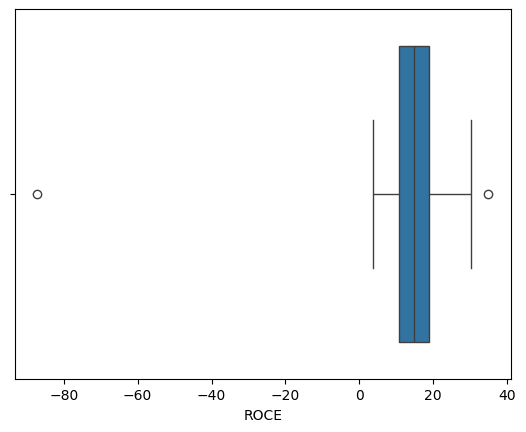

In [13]:
sns.boxplot(x=sugar['ROCE'])
plt.show()

Let us use the inter-quartile range method to deal with the outliers in this column.

In [14]:
quantile_1 = sugar['ROCE'].quantile(0.25)
quantile_3 = sugar['ROCE'].quantile(0.75)
iqr = quantile_3 - quantile_1
upper_limit = quantile_3 + 1.5 * iqr
lower_limit = quantile_1 - 1.5 * iqr
sugar = sugar[(sugar['ROCE'] >= lower_limit) & (sugar['ROCE'] <= upper_limit)]
sugar = sugar[sugar['ROCE'] > 0]

Let us check if our outliers were removed

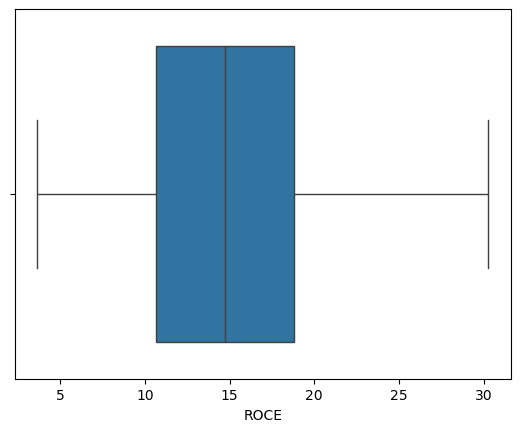

In [15]:
sns.boxplot(x=sugar['ROCE'])
plt.show()

Let us now check outliers in the 'Debt to Equity Ratio' column.

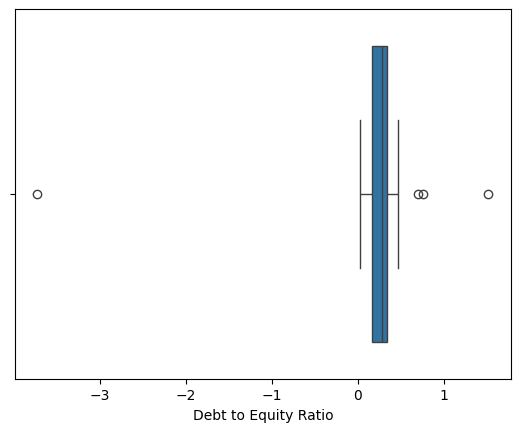

In [16]:
sns.boxplot(x=sugar['Debt to Equity Ratio'])
plt.show()

In [17]:
quantile_1 = sugar['Debt to Equity Ratio'].quantile(0.25)
quantile_3 = sugar['Debt to Equity Ratio'].quantile(0.75)
iqr = quantile_3 - quantile_1
upper_limit = quantile_3 + 1.5 * iqr
lower_limit = quantile_1 - 1.5 * iqr
sugar = sugar[(sugar['Debt to Equity Ratio'] >= lower_limit) & (sugar['Debt to Equity Ratio'] <= upper_limit)]

Again, let us verify if any outliers are left or not.

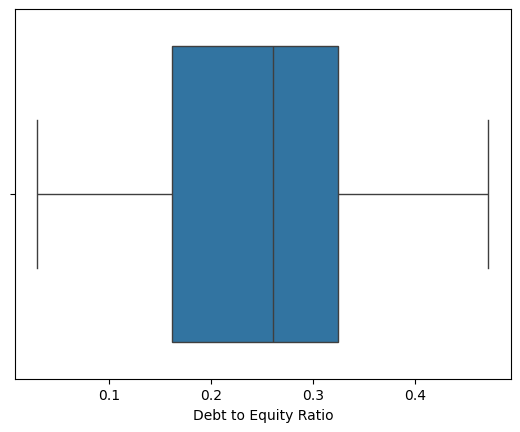

In [18]:
sns.boxplot(x=sugar['Debt to Equity Ratio'])
plt.show()

## Model Assumptions

Before we jump into building model, we first have to meet some criterias. These criterias or assumptions are necessary to build an effective model. These assumptions are:
* Independent Observations: All the observations should be independent of each other. We can assume this assumption to be true because no one company is related to other company.
* Linearity: To check which variables are linearly related to our target variable. We also need to check how much the independent variables are correlated to our dependent variable. This enables us to choose the right variables and filter out the unnecessary variables.
* No multi-colinearity: There should not be any linearity among any pair of independent variables that we choose.
* Normality: This assumption can only be checked after the model is built. The assumption of normality is met when the residuals are normally distributed.
* Homoscedasticity: The residuals should be scattered randomly around the fitted line. If the residuals are skewed to one or the other side then it means that there is some hidden correlation between the fitted values and predicted values.

### Linearity

Let us use the Pearson's Correlation method to measure the linear relationship between the independent variables and dependent variable (market cap)

In [19]:
sugar.corr(method='pearson', numeric_only=True)[['mcap']].sort_values('mcap', ascending=False)

,mcap
mcap,1.000000
Revenue,0.867257
BV,0.843919
R&S to SEC,0.732160
ROA,0.588317
NoS,0.476040
Revenue CQGR 5 yrs,0.423001
ROCE,0.401317
Revenue CAGR 2 yrs,0.378103
P/BV,0.338037


Seems like **Revenue** is most linearly related to the mcap. It is followed by **BV** (Book Value) and **R&S to SEC** (Reserves & Surplus to Share Equity Capital ratio). Ideally, a pearson correlation coefficient of 0.7 and above signifies a very high linear relationship. But to consider more factors, we will consider the variables with pearson correlation coefficient higher than 0.4. Due to this we will consider **ROA** (Return On Assets), **Revenue CQGR 5 qtrs** (compounded quarterly growth rate of revenue from the past 5 quarters), and **ROCE** (Return On Capital Equity).

### No multi-colinearity

We will check for linearity among the independent variables. If we detect a pair with high linearity among independent variables, we will drop the variable which has lower linearity with our dependent variable.

In [20]:
sugar[['Revenue', 'BV', 'R&S to SEC', 'ROA', 'Revenue CQGR 5 yrs', 'ROCE', 'mcap']].corr(method='pearson')

,Revenue,BV,R&S to SEC,ROA,Revenue CQGR 5 yrs,ROCE,mcap
Revenue,1.000000,0.923496,0.777611,0.459699,0.178381,0.334515,0.867257
BV,0.923496,1.000000,0.934371,0.416436,0.181821,0.160940,0.843919
R&S to SEC,0.777611,0.934371,1.000000,0.397632,0.137895,0.085385,0.732160
ROA,0.459699,0.416436,0.397632,1.000000,0.564958,0.798103,0.588317
Revenue CQGR 5 yrs,0.178381,0.181821,0.137895,0.564958,1.000000,0.333655,0.423001
ROCE,0.334515,0.160940,0.085385,0.798103,0.333655,1.000000,0.401317
mcap,0.867257,0.843919,0.732160,0.588317,0.423001,0.401317,1.000000


There is high linearity between **Revenue** and **BV**. So we will have to choose 1 among them. Because **Revenue** and **mcap** has high correlation between them as compared to **BV** and **mcap**, we will drop **BV**.<br>
Due to same reasons we will have to drop **R&S to SEC** too.
Similar is the case between **ROA** and **ROCE**. So we will drop **ROCE**.
Although, there is high correlation between **Revenue CQGR 5 qtrs** and **ROA**, we will not drop either of the two and try to build model with both of them.

Using pairplot to visualize relationship between the independent variables and dependent variable.

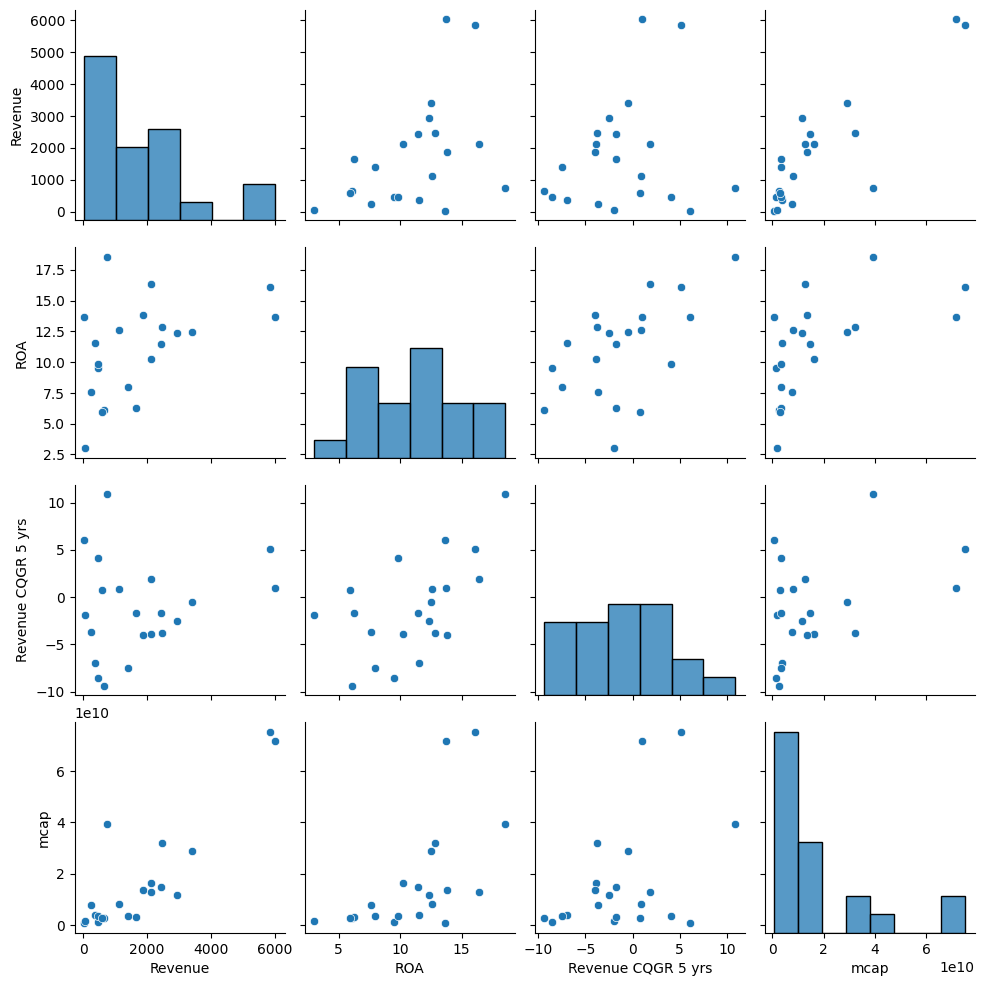

In [21]:
sns.pairplot(data=sugar[['Revenue', 'ROA', 'Revenue CQGR 5 yrs', 'mcap']])
plt.show()

In [22]:
await piplite.install('statsmodels')
from statsmodels.formula.api import ols

The OLS formula doesn't accept spaces between the independent variables, so we will have to rename the **Revenue CQGR 5 yrs** column to **Revenue_CQGR_5_qtrs**.

In [23]:
sugar.rename(columns = {'Revenue CQGR 5 yrs' : 'Revenue_CQGR_5_qtrs'}, inplace=True)

In [24]:
ols_formula = "mcap ~ Revenue + ROA + Revenue_CQGR_5_qtrs"
OLS = ols(data=sugar[['Revenue', 'ROA', 'Revenue_CQGR_5_qtrs', 'mcap']], formula=ols_formula)
model = OLS.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mcap   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     28.10
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           8.16e-07
Time:                        16:20:49   Log-Likelihood:                -510.29
No. Observations:                  21   AIC:                             1029.
Df Residuals:                      17   BIC:                             1033.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5.595e+09    8.1e+09     -0.690      0.499   -2.27e+10    1.15e+10
Revenue              9.933e+06   1.43e+06      6.929      0.000    6.91e+06     1.3e+07
ROA                  5.641e+08   7.43e+08      0.759      0.458      -1e+09    2.13e+09
Revenue_CQGR_5_qtrs  9.644e+08   5.16e+08      1.868      0.079   -1.25e+08    2.05e+09
==============================================================================
Omnibus:                        1.130   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.568   Jarque-Bera (JB):                0.805
Skew:                          -0.021   Prob(JB):                        0.669
Kurtosis:                       2.041   Cond. No.                     9.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Earlier, we had considered **ROA** as well as **Revenue_CQGR_5_qtrs** for building our model despite the correlation between them.<br>
Let us again build the model after dropping **ROA** and then check whether the adjusted R-squared has improved or not.

In [25]:
ols_formula = "mcap ~ Revenue + Revenue_CQGR_5_qtrs"
OLS = ols(data=sugar[['Revenue', 'Revenue_CQGR_5_qtrs', 'mcap']], formula=ols_formula)
model = OLS.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mcap   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     42.87
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           1.43e-07
Time:                        16:20:52   Log-Likelihood:                -510.64
No. Observations:                  21   AIC:                             1027.
Df Residuals:                      18   BIC:                             1030.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.542e+07   3.16e+09      0.018      0.986   -6.58e+09    6.69e+09
Revenue              1.041e+07   1.27e+06      8.196      0.000    7.74e+06    1.31e+07
Revenue_CQGR_5_qtrs  1.181e+09   4.25e+08      2.777      0.012    2.88e+08    2.07e+09
==============================================================================
Omnibus:                        0.671   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.715   Jarque-Bera (JB):                0.674
Skew:                           0.155   Prob(JB):                        0.714
Kurtosis:                       2.179   Cond. No.                     3.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can clearly see, although by a very less margin, the adjusted R-squared did improve after we dropped **ROA**.

In [26]:
model.resid

0    -1.586424e+10
2     8.357447e+09
3     1.095076e+10
4    -5.818760e+09
5     9.459041e+09
6    -1.280777e+09
7    -6.780737e+09
8    -8.391912e+09
9    -1.241409e+09
11    6.433648e+09
12    8.232827e+09
14    7.176844e+09
15   -4.517328e+09
16   -2.317811e+09
18    3.229881e+09
19    1.868875e+10
21   -6.385025e+09
23   -1.187848e+10
30    7.746426e+09
32   -1.153531e+10
33   -4.263834e+09
dtype: float64

### Normality

We will check whether the residuals are normally distributed or not.<br>
We can do this in 2 ways:
* Plotting histogram of residuals
* Plotting qqplot of the residuals

We will use both.

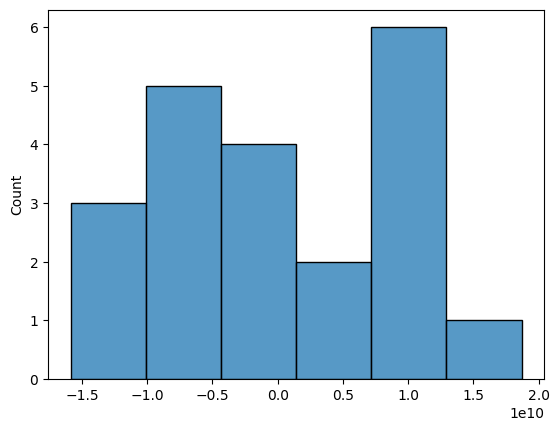

In [27]:
sns.histplot(model.resid)
plt.show()

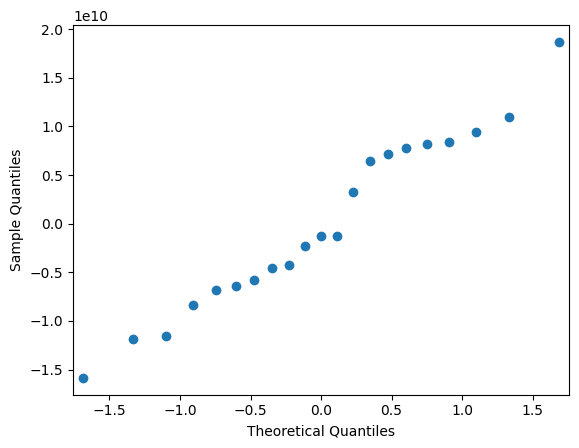

In [28]:
await piplite.install('statsmodels')
import statsmodels.api as sm
sm.qqplot(model.resid)

The normality assumption could be met only partially. But that could also be because we have very less sample size.

Let us now consider all the necessary columns and concatenate their respective residual values, and then arrange this list according to the residuals in ascending order.

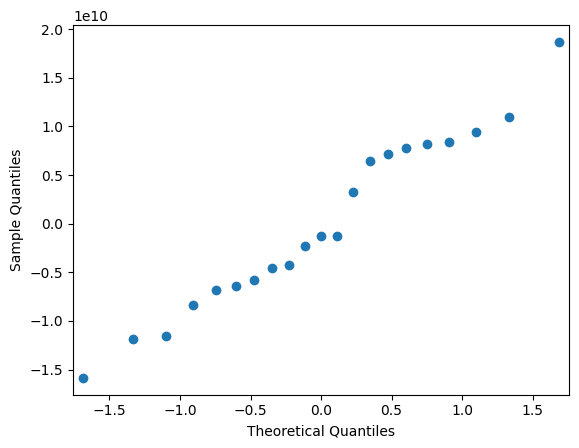

In [29]:
final = pd.concat([sugar[['Stock', 'Revenue', 'Revenue_CQGR_5_qtrs', 'mcap']], model.resid], axis=1)

In [30]:
final.rename(columns = {0 : 'Residuals'}, inplace=True)

In [31]:
final.sort_values(by=['Residuals', 'Revenue'], ascending=[True, False])

,Stock,Revenue,Revenue_CQGR_5_qtrs,mcap,Residuals
0,AVADHSUGAR,2923.9,-2.538415,1.164158e+10,-1.586424e+10
23,RANASUG,1650.4,-1.724210,3.327237e+09,-1.187848e+10
32,UTTAMSUGAR,2118.1,1.878292,1.279515e+10,-1.153531e+10
8,DHAMPURSUG,2422.8,-1.731413,1.484871e+10,-8.391912e+09
7,DHAMPURE,29.5,6.087373,7.707058e+08,-6.780737e+09
21,PONNIERODE,464.7,4.115166,3.369327e+09,-6.385025e+09
4,DALMIASUG,3399.5,-0.502783,2.904369e+10,-5.818760e+09
15,MAGADHSUGAR,1109.1,0.861228,8.104795e+09,-4.517328e+09
33,VISHWARAJ,587.7,0.805628,2.863016e+09,-4.263834e+09
16,MAWANASUG,1411.2,-7.523248,3.548679e+09,-2.317811e+09


Generally, **P/E** ratio was used to check whether a company is overbought or underbought. But with this model, we will actually come to know which of the companies are overbought and which are underbought. We will come to know how good of an indicator **P/E** is.

In [32]:
final = pd.concat([final, sugar['P/E']], axis=1)

In [33]:
final = final.reset_index(drop=True)

In [34]:
final.sort_values(by=['Residuals'])

,Stock,Revenue,Revenue_CQGR_5_qtrs,mcap,Residuals,P/E
0,AVADHSUGAR,2923.9,-2.538415,1.164158e+10,-1.586424e+10,7.703348
17,RANASUG,1650.4,-1.724210,3.327237e+09,-1.187848e+10,6.448134
19,UTTAMSUGAR,2118.1,1.878292,1.279515e+10,-1.153531e+10,7.997909
7,DHAMPURSUG,2422.8,-1.731413,1.484871e+10,-8.391912e+09,7.239032
6,DHAMPURE,29.5,6.087373,7.707058e+08,-6.780737e+09,22.020167
16,PONNIERODE,464.7,4.115166,3.369327e+09,-6.385025e+09,8.411534
3,DALMIASUG,3399.5,-0.502783,2.904369e+10,-5.818760e+09,9.576054
12,MAGADHSUGAR,1109.1,0.861228,8.104795e+09,-4.517328e+09,7.803342
20,VISHWARAJ,587.7,0.805628,2.863016e+09,-4.263834e+09,-8.105430
13,MAWANASUG,1411.2,-7.523248,3.548679e+09,-2.317811e+09,8.482732


We can observe that AVADHSUGAR, RANASUG and UTTAMSUGAR are most underbought stocks.<br>
We can understand why AVADHSUGAR and RANASUG are underbought. It might be because both of them have a negative quarter on quarter growth rate for last 5 quarters for revenue. The selling in these stocks might have caused to build a downward momentum which might have caused them to be in underbought zone. <br>
But UTTAMSUGAR checks all the points in our list. UTTAMSUGAR can be a safe bet.

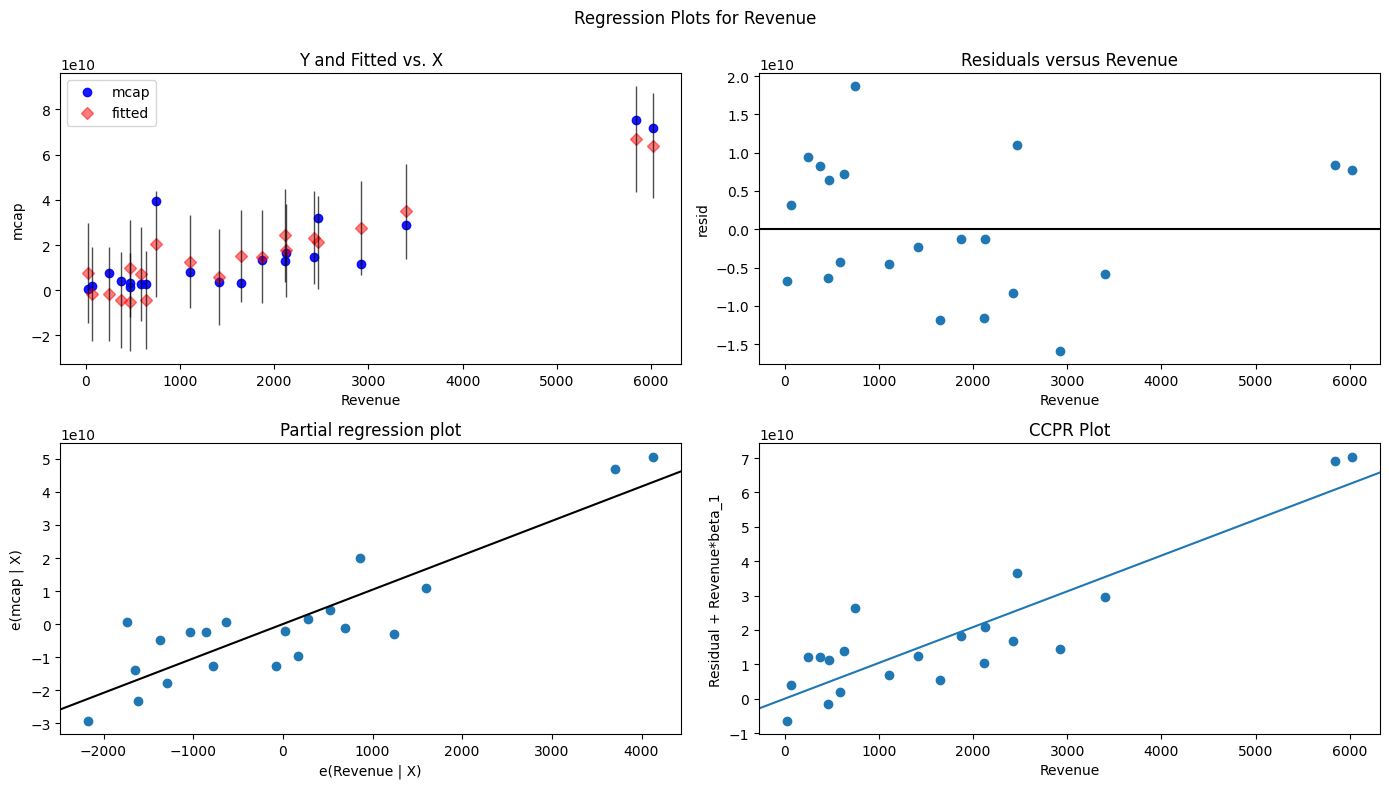

In [35]:
import statsmodels.api as sm

fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model, 'Revenue', fig=fig)

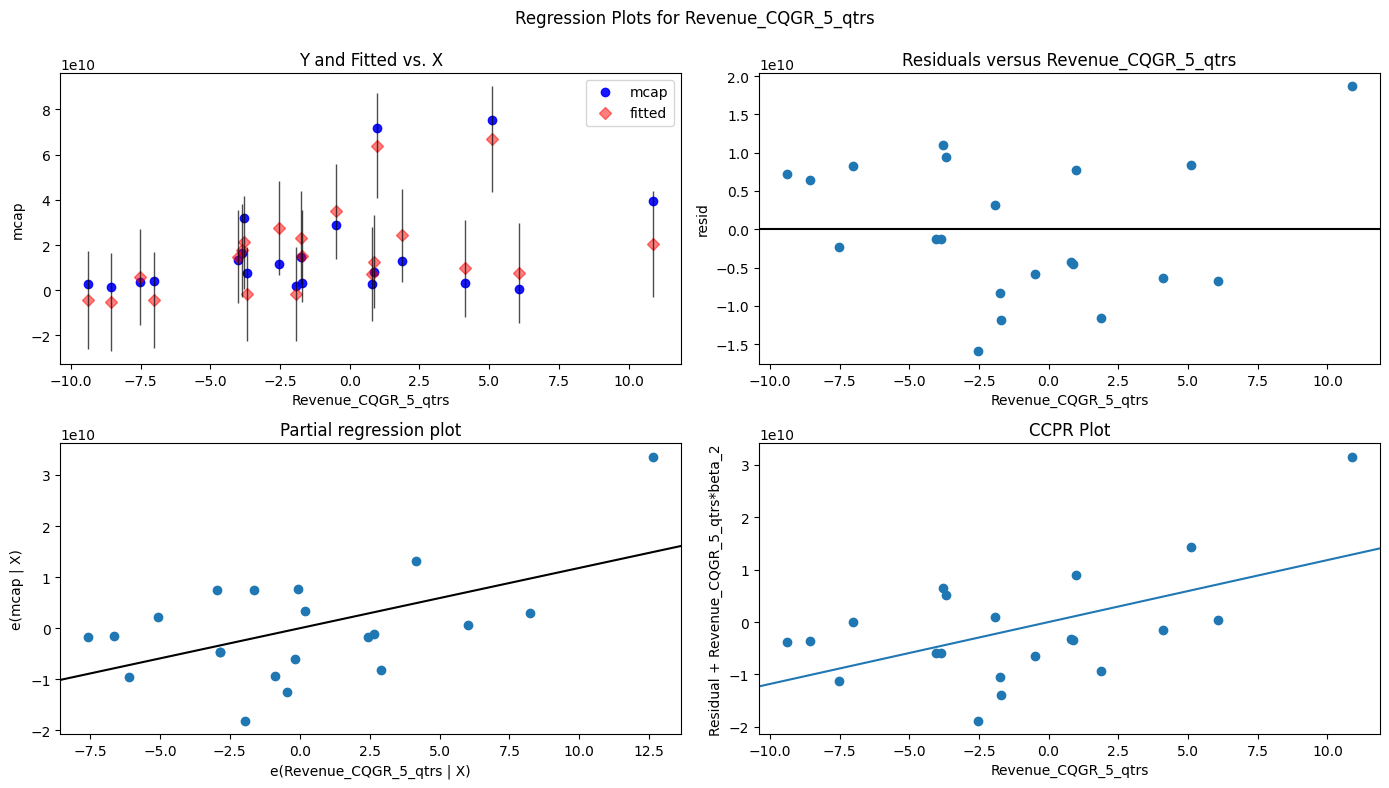

In [36]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model, 'Revenue_CQGR_5_qtrs', fig=fig)

### Homoscedasticity

We want to check whether the residuals are randomly scattered when plotted against the fitted values.

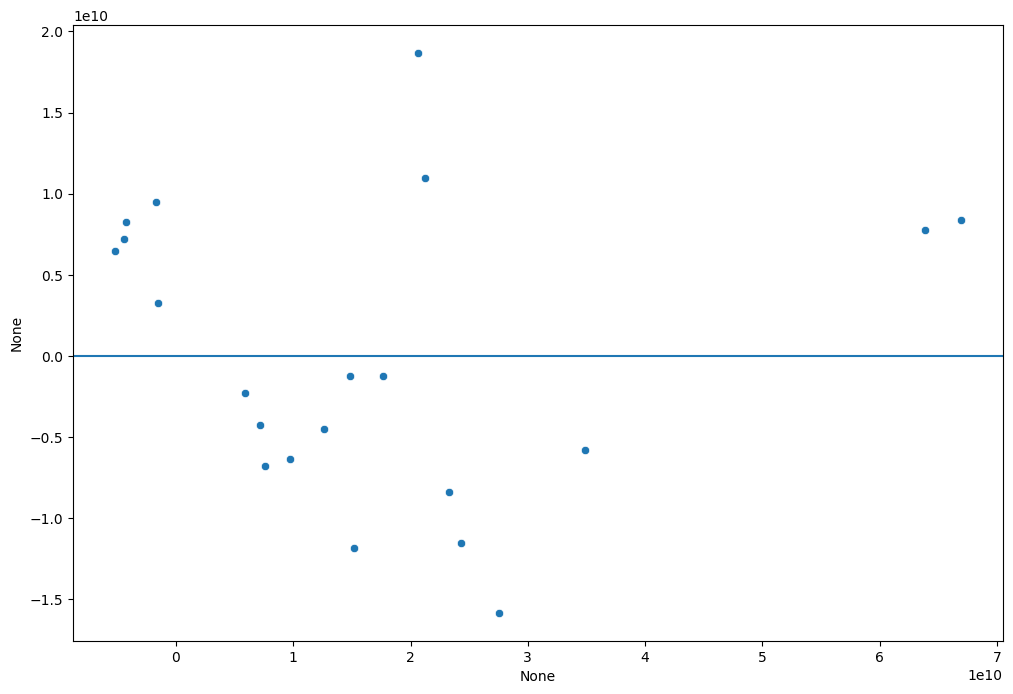

In [37]:
X = sugar[['Revenue', 'Revenue_CQGR_5_qtrs']]
fitted_values = model.predict(X)

plt.figure(figsize=(12,8))
sns.scatterplot(y=model.resid, x=fitted_values)
plt.axhline(y=0)

plt.show()

We can see that the homoscedasticity assumption is met.

Let us plot a Revenue vs Residuals scatterplot to get a visual idea of which stocks are underbought and overbought.

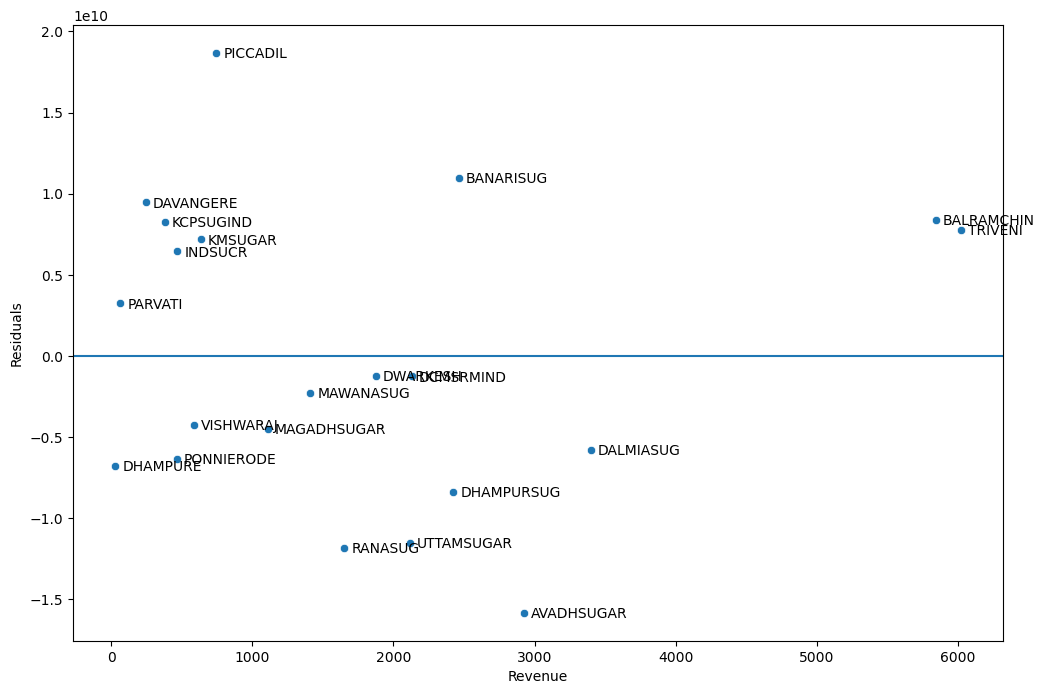

In [38]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=final, y='Residuals', x='Revenue')
plt.axhline(y=0)

for i in range(len(final)):
    plt.annotate(final['Stock'][i], (final['Revenue'][i]+50, final['Residuals'][i]-300000000))

plt.show()